In [1]:
# Example analysis for a batch of experiments
# We found the functionalities below is the most useful in practice
# It can automatically provides an overview of the trade-off for each design dimension
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from scipy.stats import rankdata
from matplotlib.ticker import MaxNLocator

%matplotlib inline
sns.set(style='ticks',context='poster')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
np.set_printoptions(precision=3, linewidth=200, suppress=True)


def list_exclude(a, b):
    return [item for item in a if item not in b]

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
        
column_exclude_options = ['format','dataset', 'task', 'trans', 'feature', 'label',
            'epoch', 'loss', 'loss_std', 
            'params', 'time_iter', 'time_iter_std', 'accuracy', 'accuracy_std', 
            'precision', 'precision_std', 'recall', 'recall_std', 'f1', 'f1_std', 'auc', 'auc_std']

def name_mapping(name):
    # you can add additional name mapping for your customize configurations
    mapping = {'act': 'Activation', 'bn':'Batch Normalization', 'drop':'Dropout', 'agg':'Aggregation',
                'l_mp':'MP layers', 'l_pre':'Pre-process layers', 'l_post': 'Post-process layers', 'stage': 'Layer connectivity',
                'lr': 'Learning rate', 'batch':'Batch size', 'optim': 'Optimizer', 'epoch': 'Training epochs', 
                'direct': 'Direction', 'head':'Multi-task heads', 'l_final':'Att final', 'l_type':'layer_type',
               'l_finalbn': 'Final BN', 'task': 'Task', 'subgraph':'subgraph', 'margin':'margin',
               'order':'order', 'norm':'norm'}
    if name in mapping:
        return mapping[name]
    else:
        return name

def get_acc(df_pivot, name, ax, plot_type='performance', has_y=True, rank_resolution=0.001, verbose=False):
    accs_np = df_pivot.fillna(df_pivot.min()).values.round(4)
    options = df_pivot.columns.values

    ranks_raw = {'Model ID':[], 'Accuracy':[], 'Acc. Ranking':[], name_mapping(name):[]}
    
    for i,row in enumerate(accs_np):
        # (1) rank is asceneding, so we neg the row
        rank_base = -row
        med = np.median(rank_base)
        for j in range(len(rank_base)):
            if abs(rank_base[j]-med) <= rank_resolution:
                rank_base[j] = med
        rank = rankdata(rank_base, method='min')
        for j in range(len(rank)):
            ranks_raw['Model ID'].append(i)
            ranks_raw['Accuracy'].append(accs_np[i,j])
            ranks_raw['Acc. Ranking'].append(rank[j])
            ranks_raw[name_mapping(name)].append(options[j])
    
    ranks_raw = pd.DataFrame(data=ranks_raw)     
    with sns.color_palette("muted"):
        if plot_type=='performance':
            splot = sns.violinplot(x=name_mapping(name), y="Accuracy",inner="box", data=ranks_raw, cut=0, ax=ax)
            ax.set_xlabel('',fontsize=48)
            if not has_y:
                ax.set_ylabel('',fontsize=48)
            else:
                ax.set_ylabel('AUC Dist.',fontsize=48)
        elif plot_type=='rank_bar':
            splot = sns.barplot(x=name_mapping(name), y="Acc. Ranking",data=ranks_raw, ax=ax)
            ax.set_ylim(bottom=1)
            ax.set_yticks([1,2])
            ax.set_xlabel('',fontsize=48)
            if not has_y:
                ax.set_ylabel('',fontsize=48)
            else:
                ax.set_ylabel('Rank Average',fontsize=48)
        elif plot_type=='rank_violin':
            sns.violinplot(x=name_mapping(name), y="Acc. Ranking",inner="box", data=ranks_raw, cut=0, ax=ax)
            ax.set_ylim(bottom=1)
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            if not has_y:
                ax.set_ylabel('',fontsize=48)
            else:
                ax.set_ylabel('Rank Dist.',fontsize=48)
        ax.xaxis.label.set_size(48)
        ax.yaxis.label.set_size(48)
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(40)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(40)

            
def plot_single(df, options_chunk, options, metric, rank_resolution):
    for names in options_chunk:
        col = 6
        row = 3
        f, axes = plt.subplots(nrows=row, ncols=col, figsize=(48, 14))
        for i,name in enumerate(names):
            name_others = copy.deepcopy(options)
            name_others.remove(name)
            df_pivot = pd.pivot_table(df, values=metric, index=name_others, columns=[name], aggfunc=np.mean)
            for j,plot_type in enumerate(['performance','rank_bar','rank_violin']):
                get_acc(df_pivot, name, axes[j, i], plot_type, has_y=True, rank_resolution=rank_resolution)
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.5, hspace=0.2)
    #     f.savefig('figs/{}.png'.format(metric), dpi=150, bbox_inches='tight')
        plt.show()

def plot_analysis(fname, division='test', dataset=None, metric='accuracy', rank_resolution=0.001, f=None, filter_rm=None):
    #results_file_path = '../run/results/{}/agg/{}.csv'.format(fname, division)
    results_file_path = '../results_experiments/{}/agg/{}.csv'.format(fname, division)
    df = pd.read_csv(results_file_path)
    df = df.fillna(0)
    #df['epoch'] += 1
    df.replace('skipconcat','skipcat',inplace=True)
    df.replace('add','sum',inplace=True)

    
    if f is not None:
        for key, val in f.items():
            if type(val) == list:
                df = df[df[key].isin(val)]
            else:
                df = df[df[key]==val]
      
    if filter_rm is not None:
        for key, val in filter_rm.items():
            if type(val) == list:
                df = df[~df[key].isin(val)]
            else:
                df = df[df[key]!=val]


    # create and filter design dimensions
    options_raw = list_exclude(list(df.columns), column_exclude_options)
    options = []
    for name in options_raw:
        column_temp = copy.deepcopy(options_raw)
        column_temp.remove(name)
        df_pivot = pd.pivot_table(df, values=metric, index=column_temp, columns=[name], aggfunc=np.mean)
        if len(df_pivot.columns)!=1:
            options.append(name)
    options_chunk = list(chunks(options, 6))
    print(division, dataset, options_chunk)
    
    if dataset is None:
        for dataset in df['dataset'].unique():
            df_dataset = df[df['dataset']==dataset]
            print('Dataset: {}'.format(dataset))
            plot_single(df_dataset, options_chunk, options, metric, rank_resolution)
    elif dataset=='all':
        plot_single(df, options_chunk, options, metric, rank_resolution)
    else:
        df_dataset = df[df['dataset']==dataset]
        print('Dataset: {}'.format(dataset))
        plot_single(df_dataset, options_chunk, options, metric, rank_resolution)



/tmp/ipykernel_492029/2697347048.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
experiment_name = 'ogbg_molhiv_baseline_grid_design'#'ogbg_molhiv_baseline_grid_design'

In [ ]:
#NOTE: worky only if working with multiple datasets

plot_analysis(experiment_name, division='val', dataset='ogbg-molhiv', metric='accuracy', rank_resolution=0)

val_best all [['layer_type', 'layers_k1', 'layers_k2', 'dilated_path_join', 'learn_alpha_residual_connection', 'ckpt_epoch'], ['ckpt_epoch_std']]


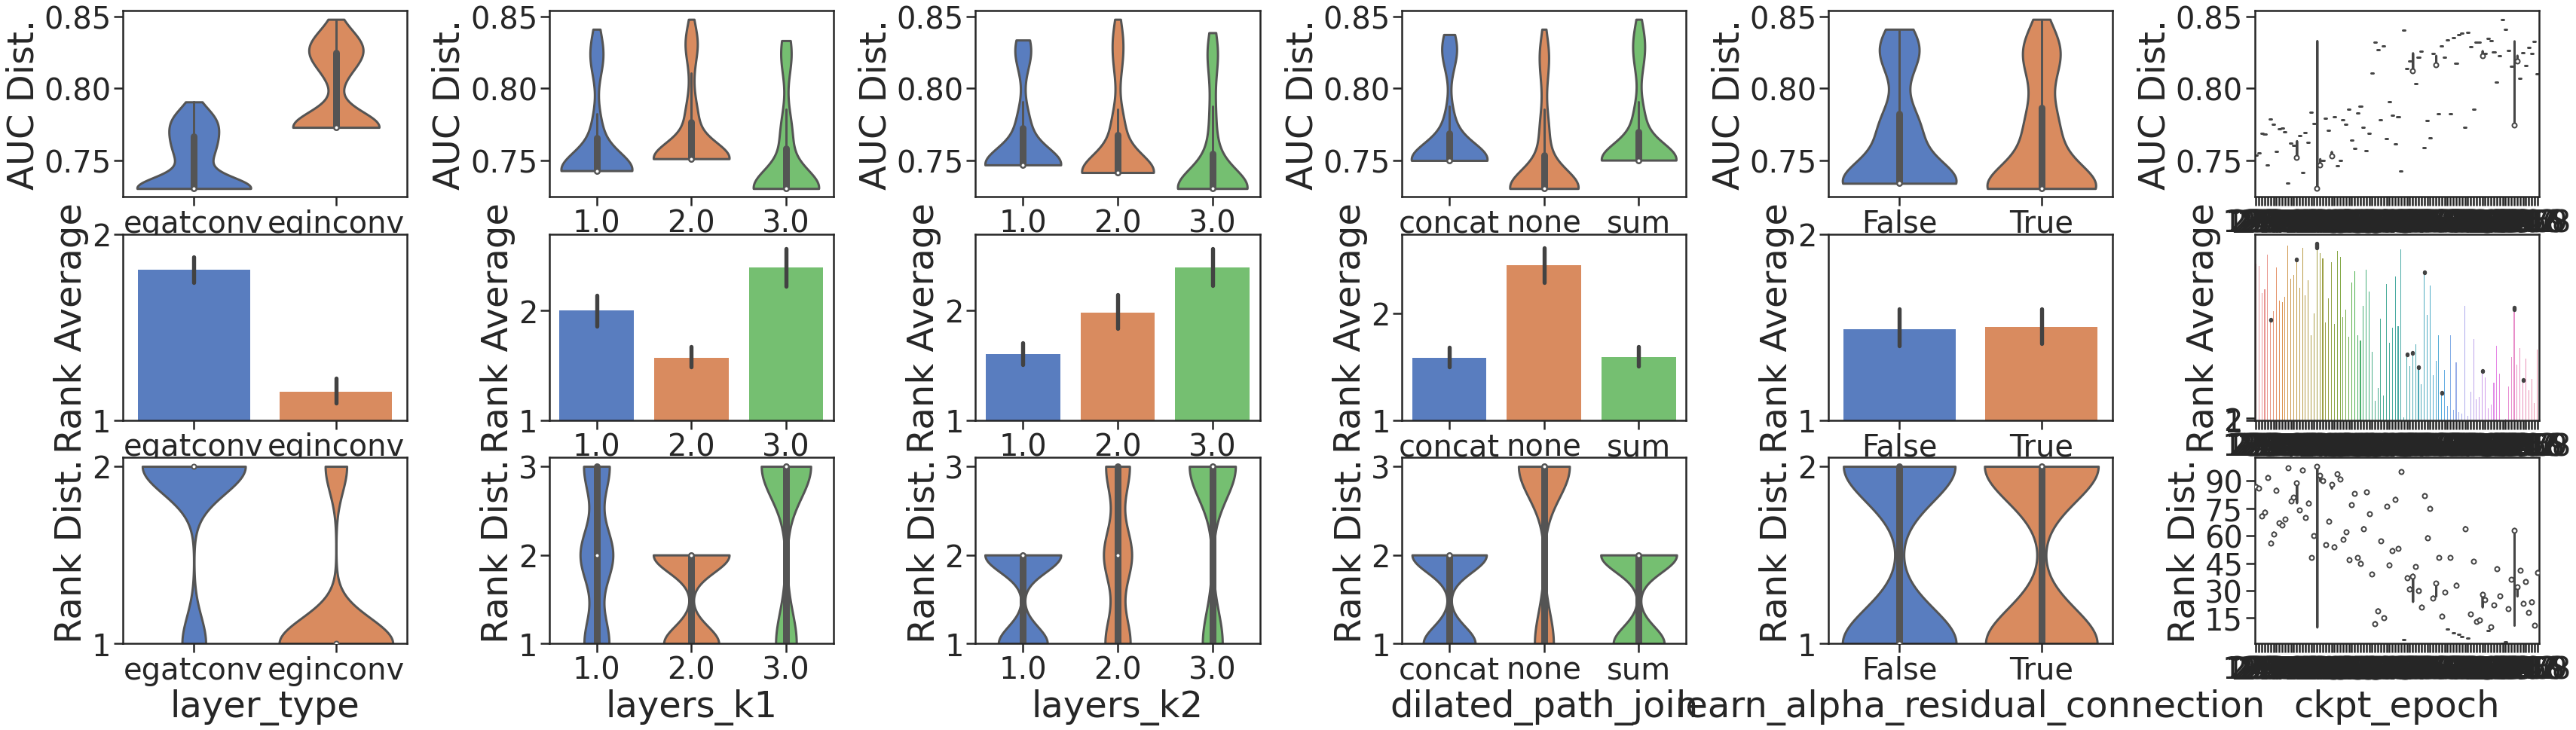

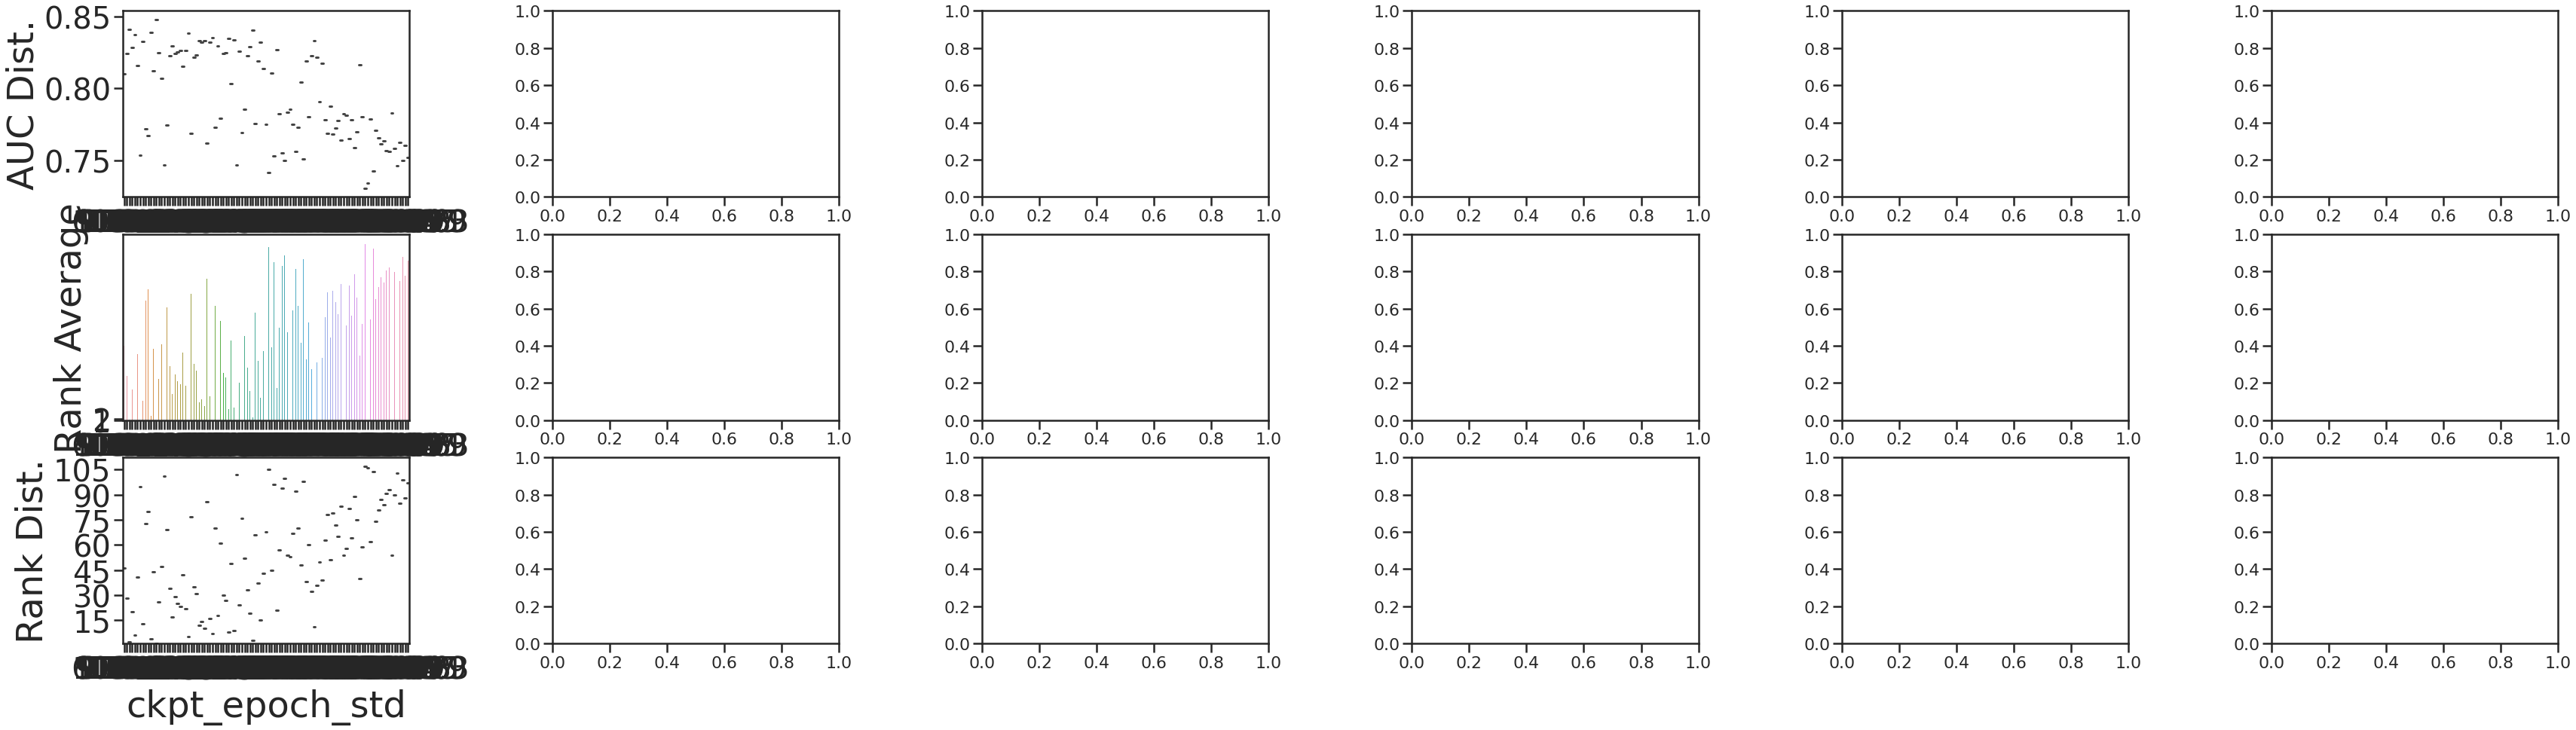

In [3]:
# analysis for all dataset in the batch
plot_analysis(experiment_name, division='val_best', dataset="all", metric='auc', f={'type':'dilated_gnn'})

In [12]:
# analysis for each dataset in the batch
plot_analysis(experiment_name, division='val', dataset=None, metric='auc', rank_resolution=0)

val None [['molhiv-type', 'layer_type', 'stage_type', 'layers_k1', 'layers_k2']]


KeyError: 'dataset'

In [4]:
def f(fname, division='val'):
    #results_file_path = '../run/results/{}/agg/{}.csv'.format(fname, division)
    results_file_path = '../results_experiments/{}/agg/{}.csv'.format(fname, division)
    df = pd.read_csv(results_file_path)
    df = df.fillna(0)
    return df

In [ ]:
#best: according to val
#best_epoch: according to best split
#_:last epoch

In [5]:
d = f(experiment_name, 'val_best')
d.sort_values('auc', ascending=False).filter(items=['name', 'type', 'layer_type', 'layers_k1', 'layers_k2', 'accuracy', 'dilated_path_join' ])

,type,layer_type,layers_k1,layers_k2,accuracy,dilated_path_join
79,dilated_gnn,eginconv,2.0,2.0,0.9822,add
64,dilated_gnn,eginconv,1.0,2.0,0.9813,none
78,dilated_gnn,eginconv,2.0,2.0,0.9820,add
84,dilated_gnn,eginconv,2.0,3.0,0.9820,add
60,dilated_gnn,eginconv,1.0,2.0,0.9806,add
86,dilated_gnn,eginconv,2.0,3.0,0.9819,concat
62,dilated_gnn,eginconv,1.0,2.0,0.9801,concat
63,dilated_gnn,eginconv,1.0,2.0,0.9818,concat
75,dilated_gnn,eginconv,2.0,1.0,0.9825,concat
90,dilated_gnn,eginconv,3.0,1.0,0.9820,add


In [6]:
d = f(experiment_name, 'val_best')
d = d[d['layer_type'] == 'eginconv']
d.sort_values('auc', ascending=False).filter(items=['type', 'layer_type', 'layers_k1', 'layers_k2', 'dilated_path_join', 'learn_alpha_residual_connection', 'auc', 'auc_std'])

,type,layer_type,layers_k1,layers_k2,dilated_path_join,learn_alpha_residual_connection,auc,auc_std
79,dilated_gnn,eginconv,2.0,2.0,add,True,0.8480,0.0119
64,dilated_gnn,eginconv,1.0,2.0,none,False,0.8411,0.0063
78,dilated_gnn,eginconv,2.0,2.0,add,False,0.8404,0.0076
84,dilated_gnn,eginconv,2.0,3.0,add,True,0.8387,0.0087
60,dilated_gnn,eginconv,1.0,2.0,add,False,0.8383,0.0085
86,dilated_gnn,eginconv,2.0,3.0,concat,True,0.8374,0.0098
62,dilated_gnn,eginconv,1.0,2.0,concat,False,0.8350,0.0143
63,dilated_gnn,eginconv,1.0,2.0,concat,True,0.8348,0.0092
75,dilated_gnn,eginconv,2.0,1.0,concat,True,0.8336,0.0069
90,dilated_gnn,eginconv,3.0,1.0,add,True,0.8332,0.0090


In [10]:
d = f(experiment_name, 'test_best')
d = d[d['layer_type'] == 'eginconv']
d.sort_values('auc', ascending=False).filter(items=['type', 'layer_type', 'layers_k1', 'layers_k2', 'act_on_last_layer_mp', 'auc', 'auc_std'])

,type,layer_type,layers_k1,layers_k2,auc,auc_std
69,dilated_gnn,eginconv,1.0,3.0,0.7802,0.0095
102,dilated_gnn,eginconv,3.0,3.0,0.7779,0.0187
73,dilated_gnn,eginconv,2.0,1.0,0.7738,0.0118
85,dilated_gnn,eginconv,2.0,3.0,0.7735,0.0193
104,dilated_gnn,eginconv,3.0,3.0,0.7716,0.0105
66,dilated_gnn,eginconv,1.0,3.0,0.7701,0.0152
68,dilated_gnn,eginconv,1.0,3.0,0.7695,0.0184
58,dilated_gnn,eginconv,1.0,1.0,0.7691,0.0122
67,dilated_gnn,eginconv,1.0,3.0,0.7690,0.0145
91,dilated_gnn,eginconv,3.0,1.0,0.7685,0.0136
